In [5]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import re


import geopandas as gpd
import plotly.express as px
from shapely.geometry import Point
import seaborn as sns
import missingno as msno

pd.set_option('display.max_columns', None)  

In [6]:
df = pd.read_csv(r'C:\Users\HP\Desktop\Electric_Vehicle_Population_Data.csv')

display(df.head(10))

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,5YJ3E1EB4L,Yakima,Yakima,WA,98908.0,2020,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,322,0,14.0,127175366,POINT (-120.56916 46.58514),PACIFICORP,5.307700e+10
1,5YJ3E1EA7K,San Diego,San Diego,CA,92101.0,2019,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,220,0,NaN,266614659,POINT (-117.16171 32.71568),NaN,6.073005e+09
2,7JRBR0FL9M,Lane,Eugene,OR,97404.0,2021,VOLVO,S60,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,22,0,NaN,144502018,POINT (-123.12802 44.09573),NaN,4.103900e+10
3,5YJXCBE21K,Yakima,Yakima,WA,98908.0,2019,TESLA,MODEL X,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,289,0,14.0,477039944,POINT (-120.56916 46.58514),PACIFICORP,5.307700e+10
4,5UXKT0C5XH,Snohomish,Bothell,WA,98021.0,2017,BMW,X5,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,14,0,1.0,106314946,POINT (-122.18384 47.8031),PUGET SOUND ENERGY INC,5.306105e+10
5,1N4AZ0CP4F,Snohomish,Everett,WA,98201.0,2015,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,84,0,38.0,107901699,POINT (-122.20596 47.97659),PUGET SOUND ENERGY INC,5.306104e+10
6,5YJ3E1EBXJ,Kitsap,Poulsbo,WA,98370.0,2018,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,215,0,23.0,475036313,POINT (-122.64681 47.73689),PUGET SOUND ENERGY INC,5.303594e+10
7,WDC0G5EB0K,Yakima,Naches,WA,98937.0,2019,MERCEDES-BENZ,GLC-CLASS,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,10,0,14.0,338148968,POINT (-120.69972 46.7309),PACIFICORP,5.307700e+10
8,1N4AZ0CP3D,Kitsap,Port Orchard,WA,98366.0,2013,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,75,0,26.0,249239623,POINT (-122.63847 47.54103),PUGET SOUND ENERGY INC,5.303509e+10
9,KNDCC3LD9K,Kitsap,Olalla,WA,98359.0,2019,KIA,NIRO,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,26,0,26.0,475609368,POINT (-122.54729 47.42602),PUGET SOUND ENERGY INC,5.303509e+10


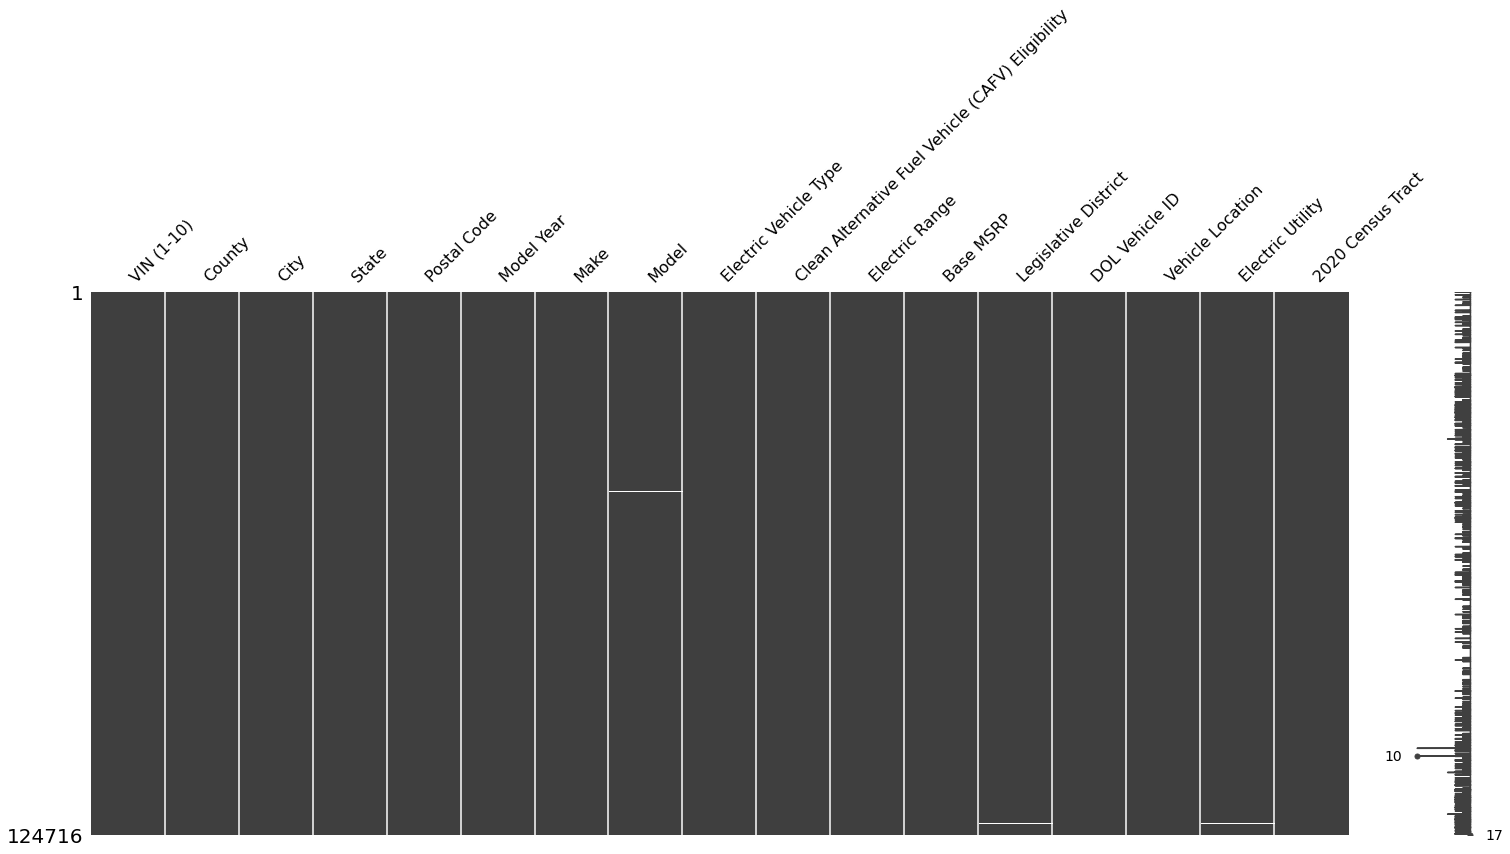

In [7]:
# Visualize missing values using missingno
msno.matrix(df);

In [8]:
# Dropping the missing values
df = df.dropna()

In [12]:
# Convert the 'Vehicle Location' column to string type
df['Vehicle Location'] = df['Vehicle Location'].astype(str)

# Extract the latitude and longitude from the 'Vehicle Location' column
def extract_coordinates(x, index):
    coords = re.findall(r'-?\d+\.\d+', x)
    if len(coords) >= 2:
        return float(coords[index])
    else:
        return None

df['latitude'] = df['Vehicle Location'].apply(lambda x: extract_coordinates(x, 0))
df['longitude'] = df['Vehicle Location'].apply(lambda x: extract_coordinates(x, 1))

df = df.dropna(subset=['latitude', 'longitude'])

In [13]:
df['Location'] = df['County'] + ', ' + df['City'] + ', ' + df['State']

In [14]:
df['Base MSRP'].value_counts()

0         120656
69900       1429
31950        402
52900        167
32250        155
54950        138
59900        127
39995        119
36900         98
44100         97
64950         87
33950         80
45600         74
34995         63
52650         61
36800         51
55700         48
53400         35
110950        21
98950         21
81100         19
75095         16
90700         16
102000        14
184400        12
43700         11
109000         7
89100          6
91250          4
32995          3
845000         1
Name: Base MSRP, dtype: int64

In [15]:
def create_price_range_category(df, column='Base MSRP'):
    def categorize_price(price):
        if price == 0:
            return "Unknown"
        elif price < 40000:
            return "Low"
        elif price < 60000:
            return "Medium"
        else:
            return "High"

    df['Price_Range_Category'] = df[column].apply(categorize_price)
    return df

df = create_price_range_category(df, column='Base MSRP')

In [16]:
def create_electric_range_category(df, column='Electric Range'):
    def categorize_range(electric_range):
        if electric_range == 0:
            return "Unknown"
        elif electric_range < 150:
            return "Short"
        elif electric_range < 300:
            return "Medium"
        else:
            return "Long"

    df['Electric_Range_Category'] = df[column].apply(categorize_range)
    return df

df = create_electric_range_category(df, column='Electric Range')

In [17]:
# Displaying the cleaned and feature engineered DataFrame
display(df.head())

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract,latitude,longitude,Location,Price_Range_Category,Electric_Range_Category
0,5YJ3E1EB4L,Yakima,Yakima,WA,98908.0,2020,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,322,0,14.0,127175366,POINT (-120.56916 46.58514),PACIFICORP,5.307700e+10,-120.56916,46.58514,"Yakima, Yakima, WA",Unknown,Long
3,5YJXCBE21K,Yakima,Yakima,WA,98908.0,2019,TESLA,MODEL X,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,289,0,14.0,477039944,POINT (-120.56916 46.58514),PACIFICORP,5.307700e+10,-120.56916,46.58514,"Yakima, Yakima, WA",Unknown,Medium
4,5UXKT0C5XH,Snohomish,Bothell,WA,98021.0,2017,BMW,X5,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,14,0,1.0,106314946,POINT (-122.18384 47.8031),PUGET SOUND ENERGY INC,5.306105e+10,-122.18384,47.80310,"Snohomish, Bothell, WA",Unknown,Short
5,1N4AZ0CP4F,Snohomish,Everett,WA,98201.0,2015,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,84,0,38.0,107901699,POINT (-122.20596 47.97659),PUGET SOUND ENERGY INC,5.306104e+10,-122.20596,47.97659,"Snohomish, Everett, WA",Unknown,Short
6,5YJ3E1EBXJ,Kitsap,Poulsbo,WA,98370.0,2018,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,215,0,23.0,475036313,POINT (-122.64681 47.73689),PUGET SOUND ENERGY INC,5.303594e+10,-122.64681,47.73689,"Kitsap, Poulsbo, WA",Unknown,Medium


In [18]:
def plot_value_counts(df, column, top_n=None):
    # Get the value counts for the specified column
    value_counts = df[column].value_counts()
    
    if top_n:
        value_counts = value_counts.head(top_n)
    
    # Set up the subplots
    fig, axes = plt.subplots(1, 2, figsize=(20, 7))
    
    # Create the pie chart
    value_counts.plot(kind='pie', ax=axes[0], autopct='%.1f%%', startangle=90, colors=sns.color_palette('pastel'))
    axes[0].set_ylabel('')
    axes[0].set_title(f'Percentage of {column}', fontsize=14)
    
    # Create the bar chart
    sns.barplot(x=value_counts.index, y=value_counts.values, ax=axes[1], palette='pastel')
    axes[1].set_title(f'Count of {column}', fontsize=14)
    axes[1].set_xlabel(column)
    axes[1].set_ylabel('Count')
    axes[1].tick_params(axis='x', rotation=30)

    for i, v in enumerate(value_counts.values):
        axes[1].text(i, v + 0.5, str(v), horizontalalignment='center', fontsize=12)
    
    # Set the suptitle for the entire figure
    fig.suptitle(f'{column} Distribution', fontsize=18, y=1.03)
    
    # Show the plots
    plt.show()


In [19]:

def plot_coordinates_seaborn(df, cmap_column=None, top_n=None, figsize=(15, 10)):
    # Drop duplicate latitude and longitude pairs
    unique_coordinates = df[['latitude', 'longitude']].drop_duplicates()

    if cmap_column and top_n:
        # Include the cmap_column in the unique_coordinates DataFrame
        unique_coordinates[cmap_column] = df[cmap_column]

        # Get the top N most frequent categories in the specified column
        top_categories = unique_coordinates[cmap_column].value_counts().head(top_n).index.tolist()

        # Filter the unique_coordinates DataFrame to keep only the top N categories
        filtered_coordinates = unique_coordinates[unique_coordinates[cmap_column].isin(top_categories)]

        # Create a scatter plot using Seaborn with hue parameter
        plt.figure(figsize=figsize)
        sns.scatterplot(data=filtered_coordinates, x='longitude', y='latitude', hue=cmap_column, palette='viridis', edgecolor=None, s=50)
        plt.title(f'Latitude and Longitude Points (Top {top_n} {cmap_column})')
    else:
        # Create a scatter plot using Seaborn without hue parameter
        plt.figure(figsize=figsize)
        sns.scatterplot(data=unique_coordinates, x='longitude', y='latitude', color='darkcyan', edgecolor=None, s=50)
        plt.title('Latitude and Longitude Points')

    # Show the plot
    plt.show()


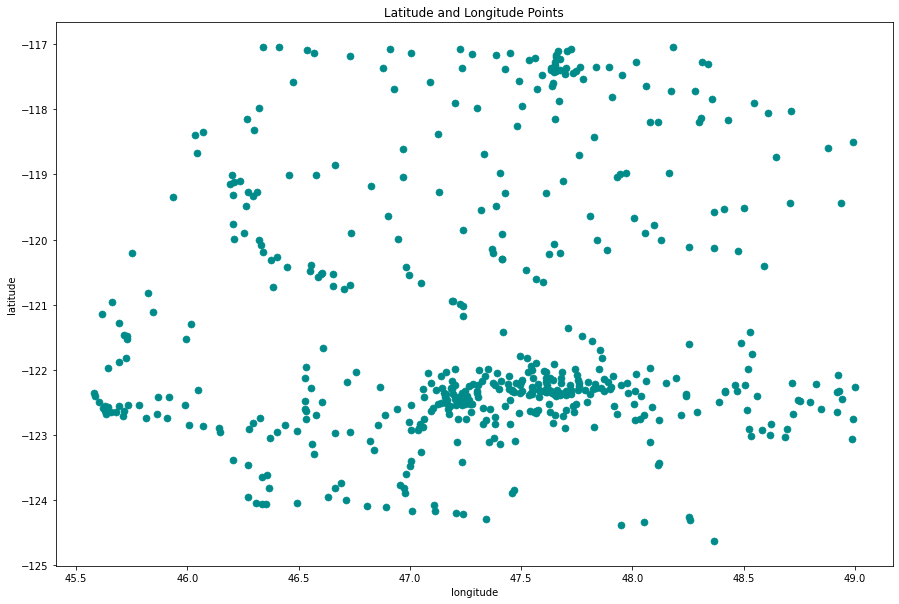

In [20]:
plot_coordinates_seaborn(df) 

Electric Car Dataset Analysis: Location¶


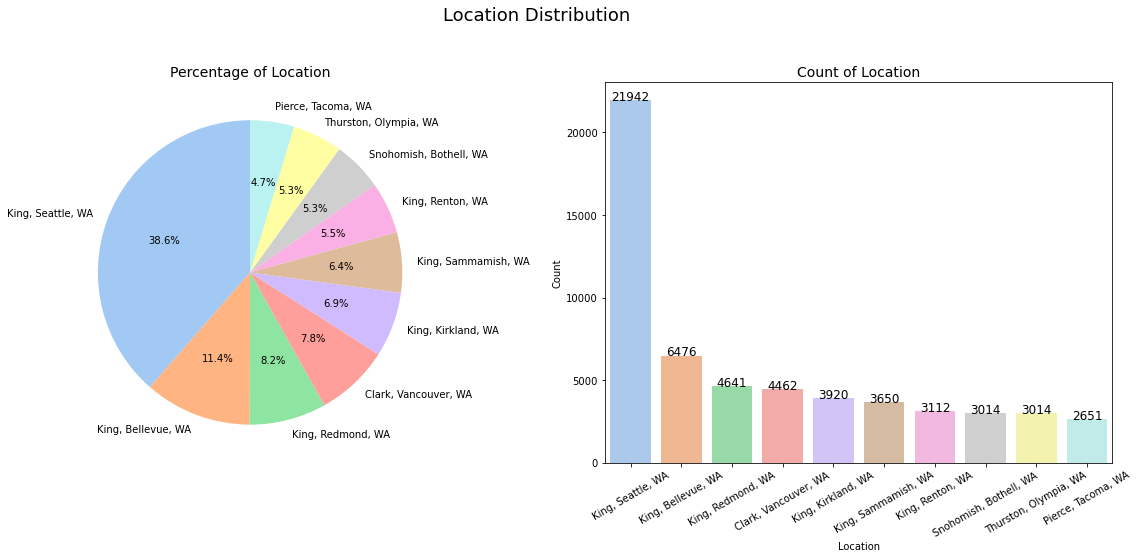

In [21]:
plot_value_counts(df, 'Location', top_n=10)


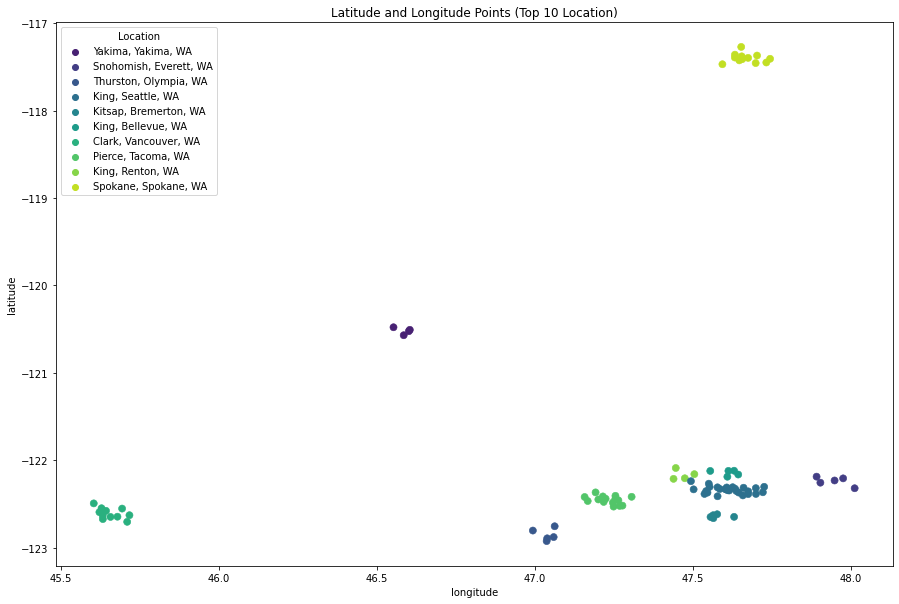

In [22]:
plot_coordinates_seaborn(df, cmap_column='Location', top_n=10) 


Electric Car Dataset Analysis: CAFV Eligibility¶


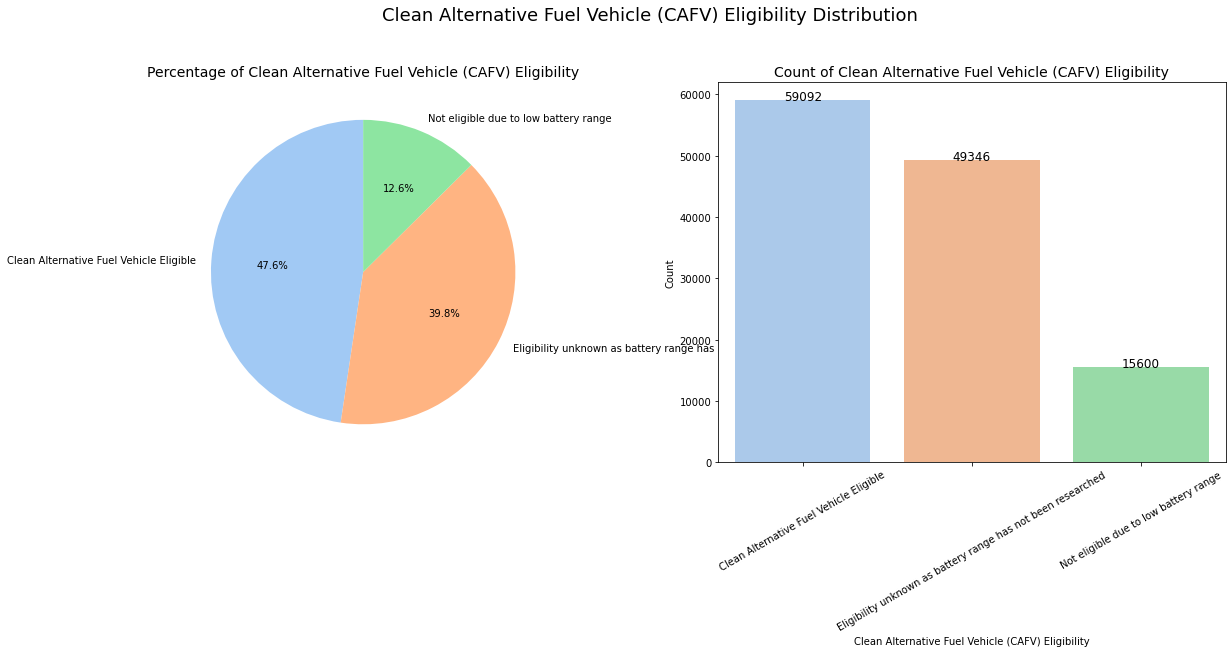

In [25]:
plot_value_counts(df, 'Clean Alternative Fuel Vehicle (CAFV) Eligibility', top_n=3)

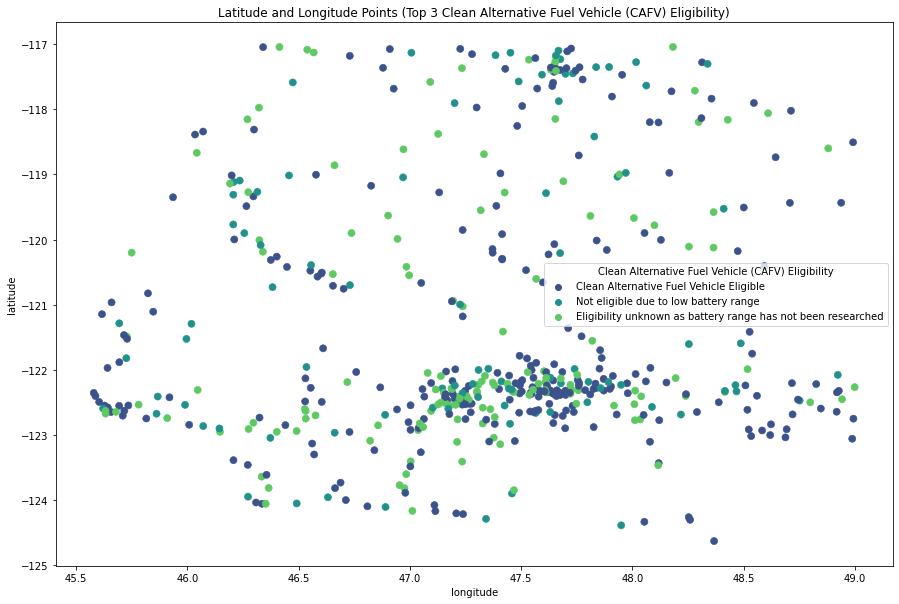

In [26]:
plot_coordinates_seaborn(df, cmap_column='Clean Alternative Fuel Vehicle (CAFV) Eligibility', top_n=3) 


Electric Car Dataset Analysis: Make¶


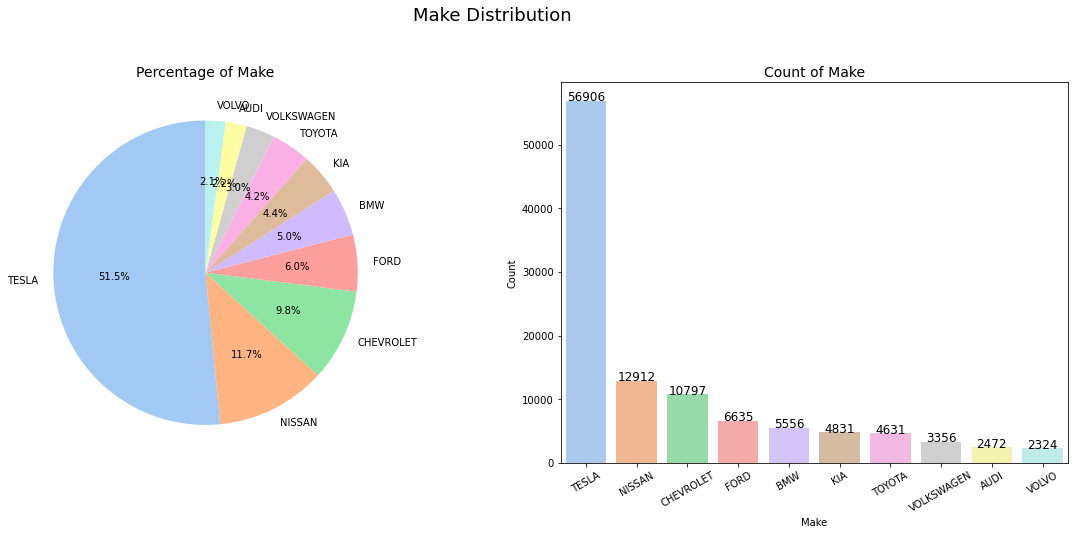

In [27]:
plot_value_counts(df, 'Make', top_n=10)


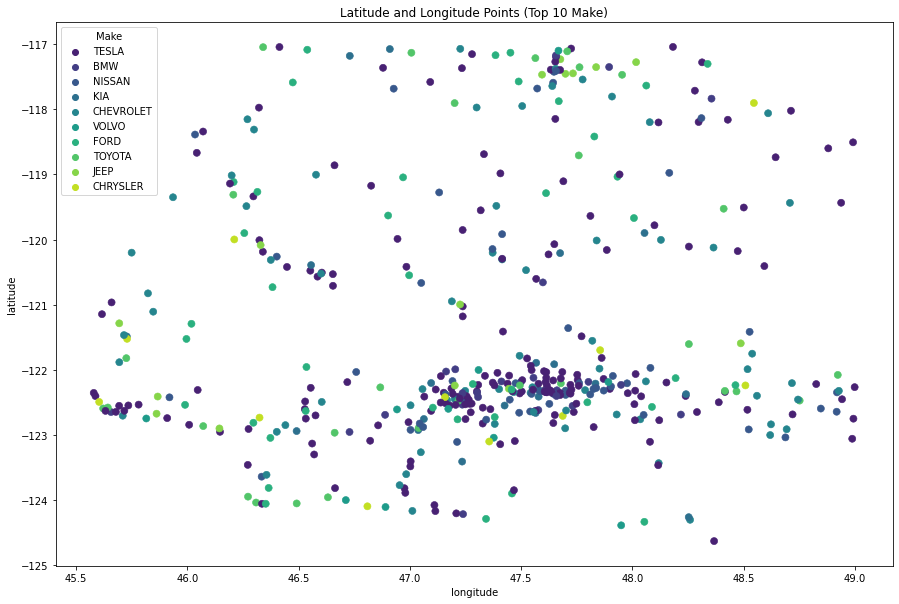

In [28]:
plot_coordinates_seaborn(df, cmap_column='Make', top_n=10) 


Electric Car Dataset Analysis: Model¶


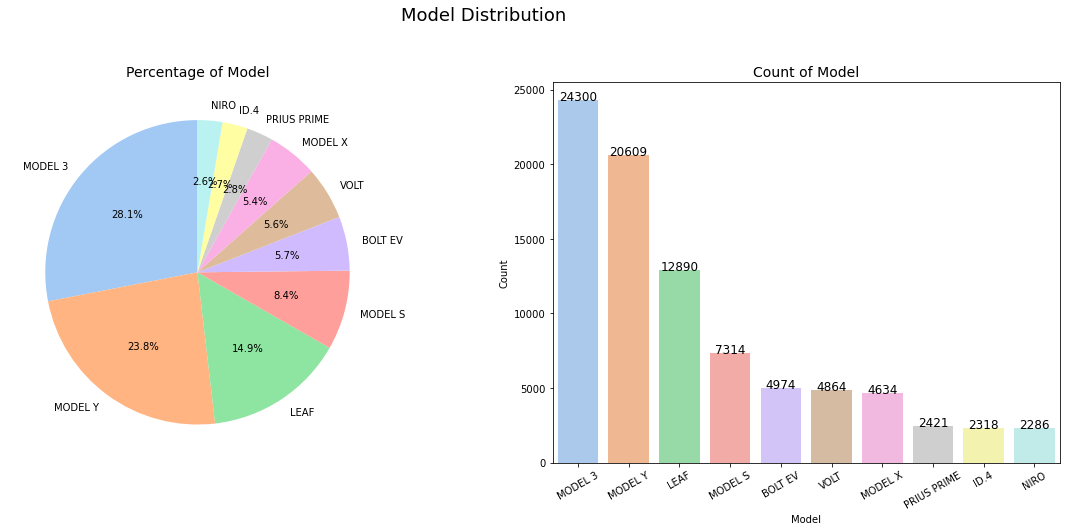

In [29]:
plot_value_counts(df, 'Model', top_n=10)


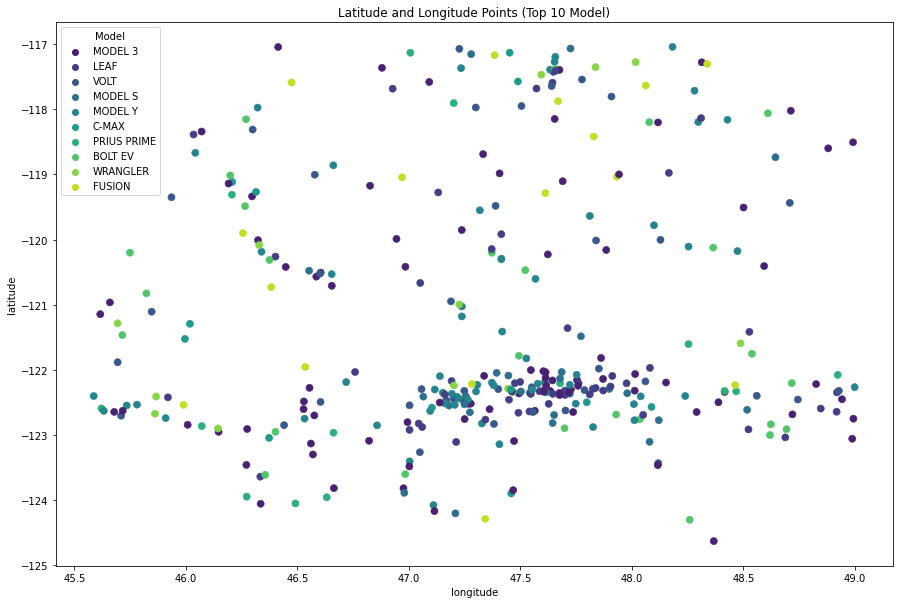

In [30]:
plot_coordinates_seaborn(df, cmap_column='Model', top_n=10) 


Electric Car Dataset Analysis: Electric Vehicle Type¶


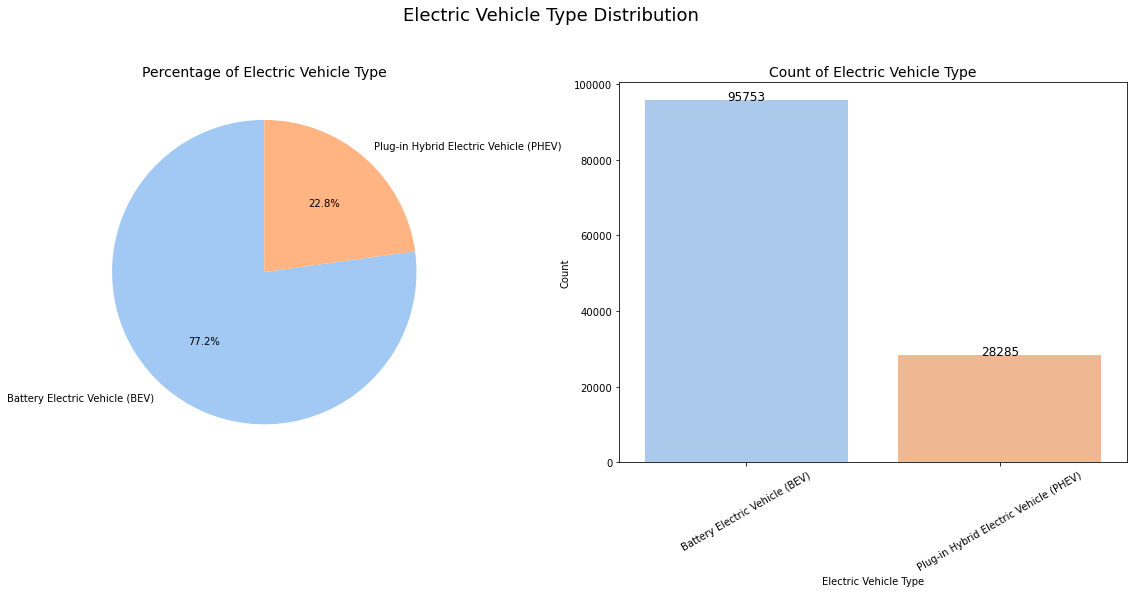

In [31]:
plot_value_counts(df, 'Electric Vehicle Type', top_n=2)


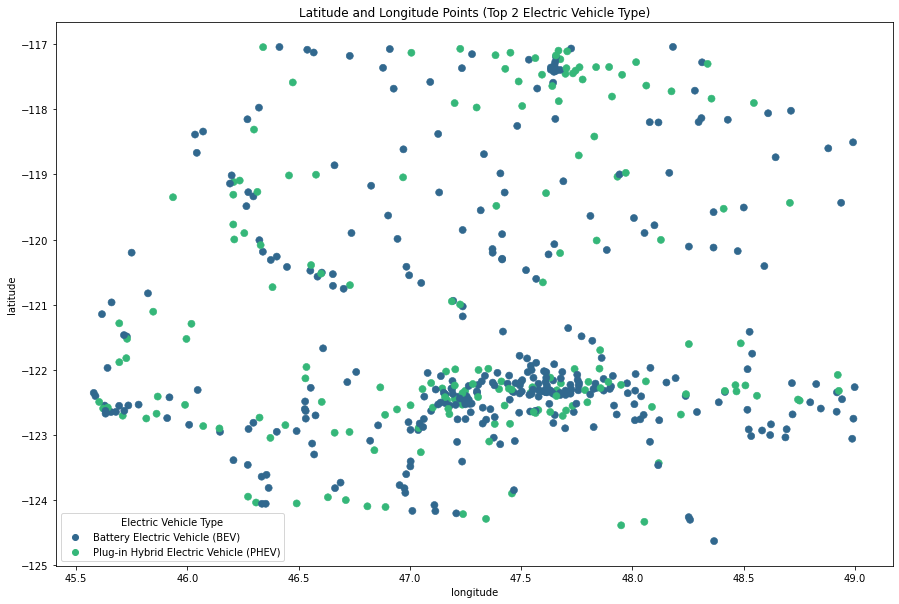

In [32]:
plot_coordinates_seaborn(df, cmap_column='Electric Vehicle Type', top_n=2) 


Electric Car Dataset Analysis: Price Range Category¶


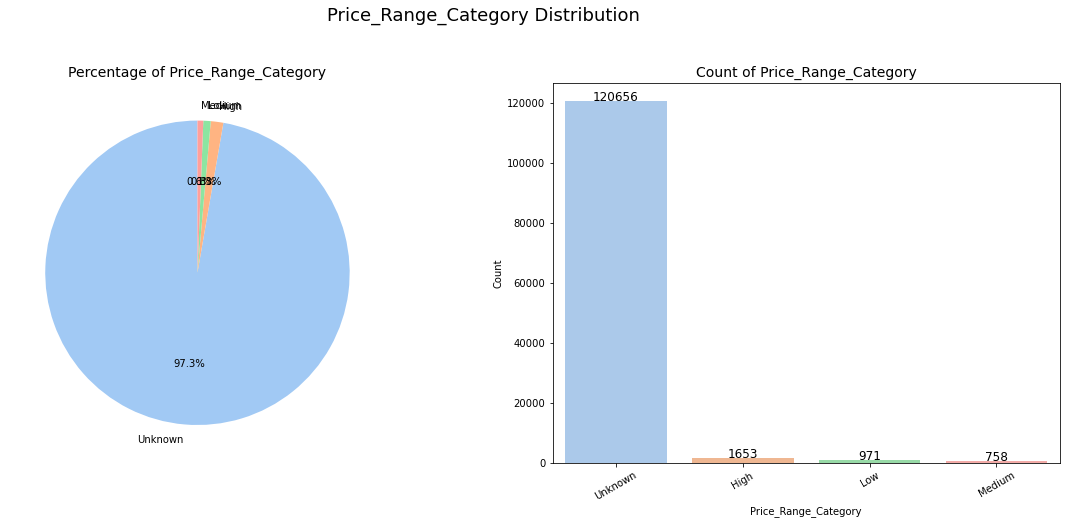

In [34]:
plot_value_counts(df, 'Price_Range_Category', top_n=4)


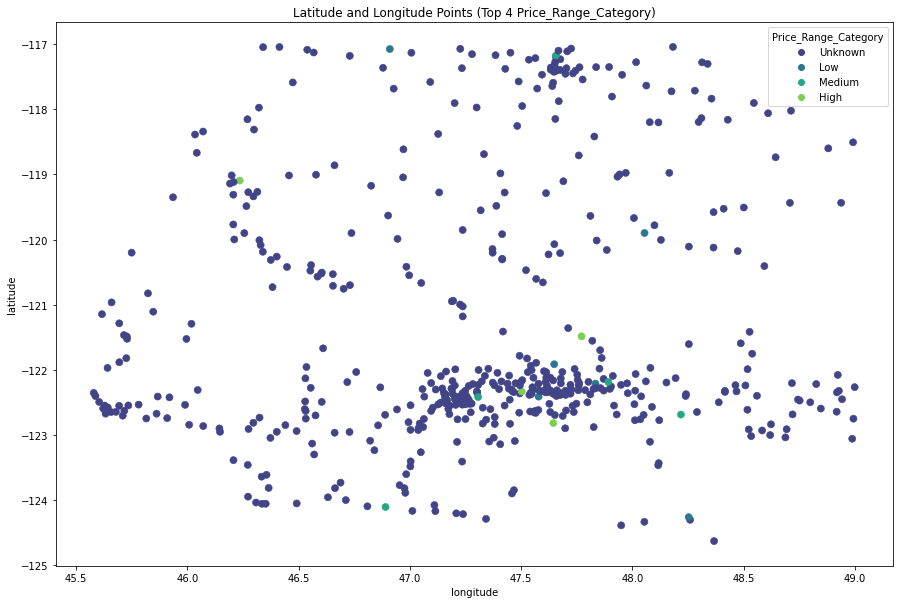

In [35]:
plot_coordinates_seaborn(df, cmap_column='Price_Range_Category', top_n=4) 


Electric Car Dataset Analysis: Electric Utility¶


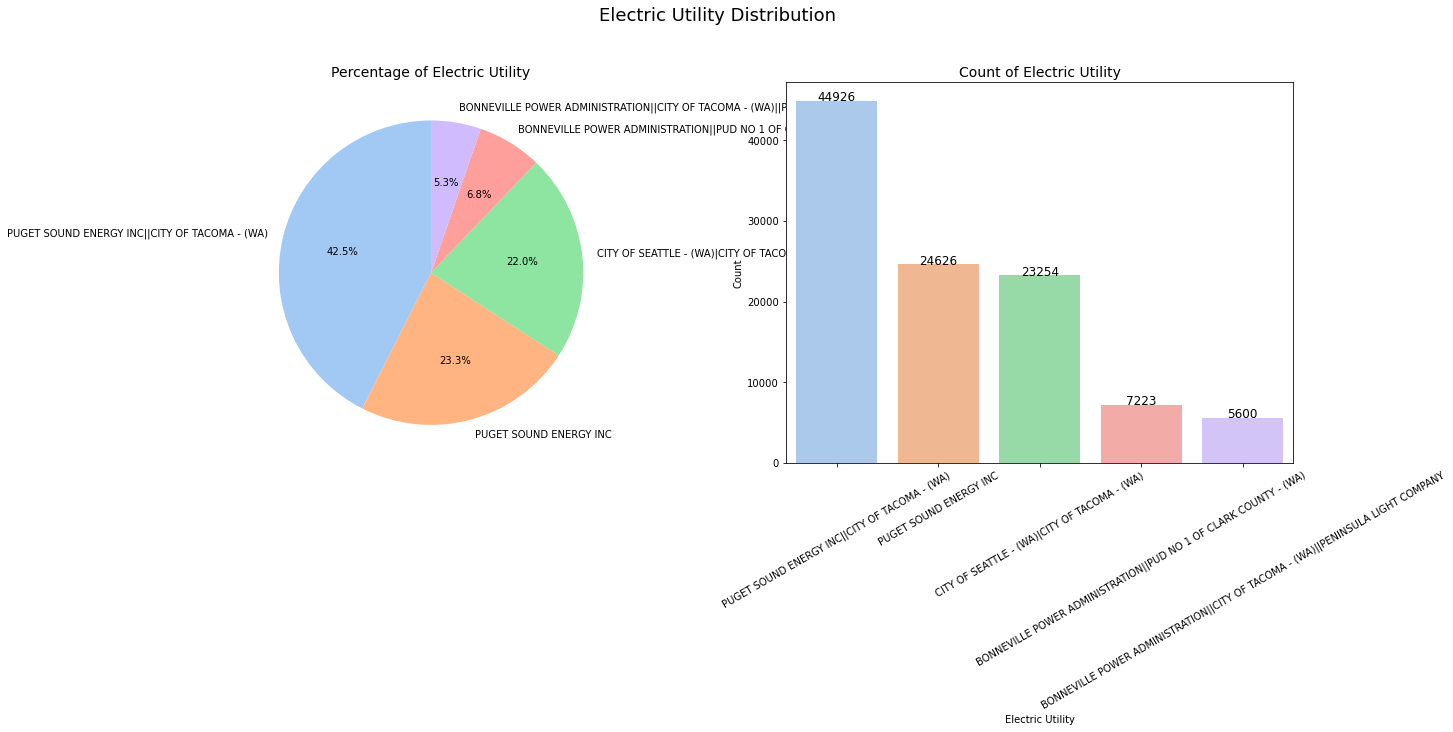

In [36]:
plot_value_counts(df, 'Electric Utility', top_n=5)


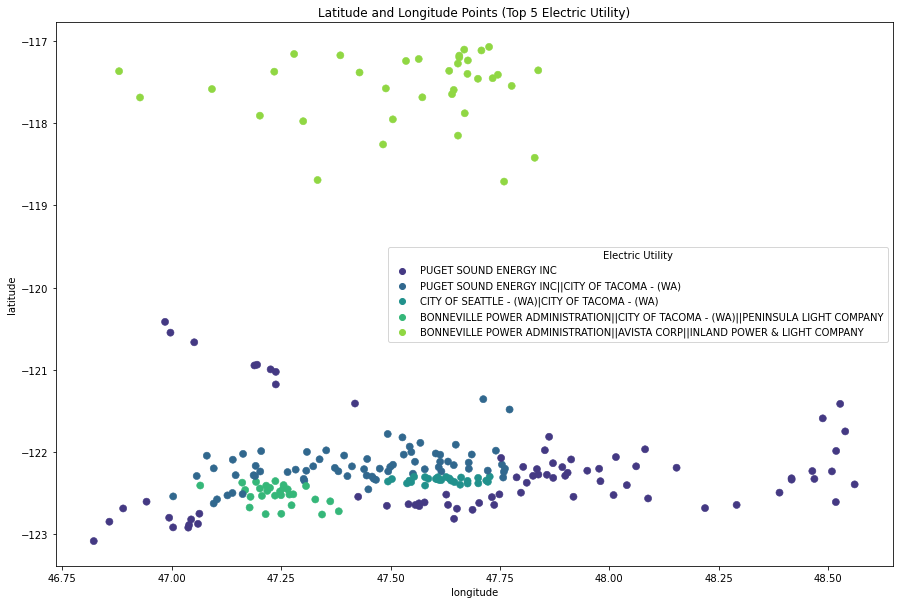

In [37]:
plot_coordinates_seaborn(df, cmap_column='Electric Utility', top_n=5) 
